In [1]:
from bids_loader.stimuli.game import  make_plot_explorer, replay_bk2
import os.path as op
import numpy as np
import pandas as pd
import glob
import retro
import json

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/pandas/compat/numpy/function.py:125: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(_np_version) >= LooseVersion("1.17.0"):


In [2]:
allbk2s = sorted(glob.glob('/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi/*/*/*/*.bk2'))
# Find a cleared file
for bk2_fpath in allbk2s:
    with open(bk2_fpath.replace('.bk2', '.json'), 'rb') as f:
        info_dict = json.load(f)
    if info_dict['Level'] == 'level-1':
        if info_dict['Cleared'] == True:
            print(bk2_fpath)
            break

/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi/sub-01/ses-002/gamelogs/sub-01_ses-002_task-shinobi_run-01_level-1_rep-01.bk2


In [24]:
bk2_fpath = allbk2s[53]

In [3]:
replay = replay_bk2(bk2_fpath, skip_first_step=True, inttype=retro.data.Integrations.STABLE)#, game=None, scenario=None, inttype=None)
all_frames = []
all_keys = []
all_info = []
for frame, keys, annotations, sound in replay:
    all_keys.append(keys)
    all_info.append(annotations["info"])
    all_frames.append(frame)


/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/gym/utils/seeding.py:160: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/gym/utils/seeding.py:204: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "


In [19]:
annotations['info'].keys()

dict_keys(['backtreegroundblue', 'Y_special_acc', 'backlastTree', 'instantScore', 'backbrush', 'backtreegroundblack', 'backbackgroundblue', 'a 4', 'backbackground', 'backbackgroundblack', 'backTree', 'a1', 'X_screen_total', 'Y_acc', 'ninjitsu', 'first enemy', 'enemy ', 'health', 'ride', 'strange', 'status', 'section', 'lives', 'score', 'shurikens', 'backtreegroundlastcolor', 'a 3 teleport dg', 'Y_player', 'typeOfNinjitsu', 'backbuissonblack', 'Y_screen', 'X_screen', 'X_player', 'DisapearLeaves', 'a 2 position en', 'backbackground(e-c)', 'blackScreen'])

<IPython.core.display.Javascript object>


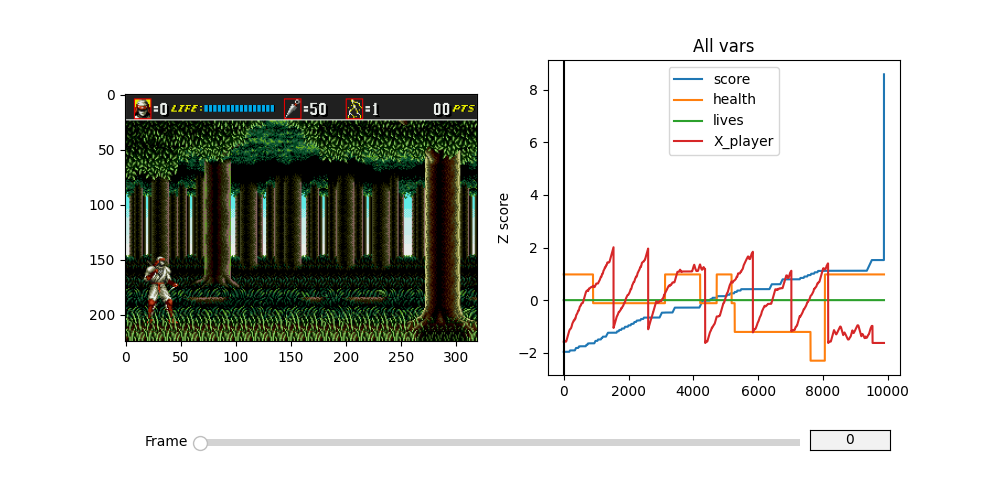

1310
4
1
2245


In [30]:
%matplotlib notebook
# TODO : 
# - Add autoscale
# - fix X player
make_plot_explorer(bk2_fpath, skip_first_step=True, labels = ["score", "health", "lives", "X_player"], game=None, scenario=None, inttype=retro.data.Integrations.STABLE, rescale=True)

In [ ]:
import matplotlib.pyplot as plt

def save_frame(all_frames, frame, output_file):
    """
    Save a frame to a file.
    """
    # Create a new figure, and plot just the frame we want to save
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(all_frames[frame], interpolation='nearest')
    #ax.set_title('Frame {}'.format(len(all_frames)))
    ax.set_axis_off()
    plt.savefig(output_file)
    plt.close(fig)

save_frame(all_frames, 1700, '../reports/figures/game-examples_level-1_midstage.png')

In [29]:
# Local copy of bids_loader.stimuli.game to fix X player in the replay explorer

import retro
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import Tensor
from matplotlib.widgets import Slider, TextBox
import pandas as pd
from scipy.stats import zscore

def replay_bk2(
    bk2_path, skip_first_step=True, game=None, scenario=None, inttype=retro.data.Integrations.CUSTOM_ONLY
):
    """Make an iterator that replays a bk2 file, returning frames, keypresses and annotations.

    Example
    -------
    ```
    all_frames = []
    all_keys = []
    for frame, keys, annotations, sound in replay_bk2(path):
        all_frames.append(frame)
        all_keys.append(keys)
    ```

    Parameters
    ----------
    bk2_path : str
        Path to the bk2 file to replay.
    skip_first_step : bool
        Whether to skip the first step before starting the replay. The intended use of
        gym retro is to do so (i.e. True) but if the recording was not initiated as intended
        per gym-retro, not skipping (i.e. False) might be required. Default is True.
    scenario : str
        Path to the scenario json file. If None, the scenario.json file in the game integration
        folder will be used. Default is None.
    inttype : gym-retro Integration
        Type of gym-retro integration to use. Default is `retro.data.Integrations.CUSTOM_ONLY`
        for custom integrations, for default integrations shipped with gym-retro, use
        `retro.data.Integrations.STABLE`.

    Yields
    -------
    frame : numpy.ndarray
        Current frame of the replay, of shape (H,W,3).
    keys : list of bool
        Current keypresses, list of booleans stating whicn key is pressed or not. The ordered name
        of the keys is in `emulator.buttons`.
    annotations : dict
        Dictonary containing the annotations of the game : reward, done condition and the values of
        the variables that are extracted from the emulator's memory.
    sound : dict
        Dictionnary containing the sound output from the game : audio and audio_rate.
    """
    movie = retro.Movie(bk2_path)
    if game == None:
        game = movie.get_game()
    emulator = retro.make(game, scenario=scenario, inttype=inttype)
    emulator.initial_state = movie.get_state()
    emulator.reset()
    if skip_first_step:
        movie.step()
    while movie.step():
        keys = []
        for p in range(movie.players):
            for i in range(emulator.num_buttons):
                keys.append(movie.get_key(i, p))
        frame, rew, done, info = emulator.step(keys)
        sound = {"audio": emulator.em.get_audio(), "audio_rate": emulator.em.get_audio_rate()}
        annotations = {"reward": rew, "done": done, "info": info}
        yield frame, keys, annotations, sound


def get_variables_from_replay(bk2_fpath, skip_first_step, save_gif=False, duration=10, game=None, scenario=None, inttype=retro.data.Integrations.CUSTOM_ONLY):
    """Replay the file and returns a formatted dict containing game variables.

    Parameters
    ----------
    bk2_fpath : str
        Full path to the bk2 file
    skip_first_step : bool
        Remove first step of replay if necessary.
    save_gif : bool, optional
        Saves a gif of the replay in the parent folder, by default False
    duration : int, optional
        Duration of a frame in the gif file, by default 10
    game : str, optional
        Game name, defaults to movie.get_game(), by default None
    scenario : str, optional
        Scenario name, by default None
    inttype : gym-retro Integration, optional
        Integration specification, can be STABLE or CUSTOM_ONLY, by default retro.data.Integrations.CUSTOM_ONLY

    Returns
    -------
    dict
        Dictionnary of game variables, as specified in the data.json file. Each entry is a list with one value per frame.
    """
    replay = replay_bk2(bk2_fpath, skip_first_step=skip_first_step, game=game, scenario=scenario, inttype=inttype)
    all_frames = []
    all_keys = []
    all_info = []
    for frame, keys, annotations, sound in replay:
        all_keys.append(keys)
        all_info.append(annotations["info"])
        if save_gif:
            all_frames.append(frame)
    repetition_variables = reformat_info(all_info, all_keys, bk2_fpath, game=game)

    if annotations['done'] != True:
        print(f"Warning : done condition have not been satisfied, try changing the value of skip_first_frame.")
                                         
    if save_gif:
        all_frames = np.moveaxis(np.array(all_frames), -1, 1)
        save_GIF(all_frames, bk2_fpath.replace(".bk2", ".gif"), duration=duration, optimize=False)
    return repetition_variables

def reformat_info(info, keys, bk2_fpath, game=None):
    """Create dict structure from info extracted during the replay.

    Parameters
    ----------
    info : list
        List of info (one per replay frame)
    keys : list
        List of keys (one per replay frame)
    bk2_fpath : str
        Full path to the bk2
    game : str, optional
        Game name, by default None

    Returns
    -------
    dict
        Dict structure with one entry per variable, each entry is a list with one value per frame.
    """
    repetition_variables = {}
    repetition_variables["filename"] = bk2_fpath
    repetition_variables["level"] = bk2_fpath.split("/")[-1].split("_")[-2]
    repetition_variables["subject"] = bk2_fpath.split("/")[-1].split("_")[0]
    repetition_variables["session"] = bk2_fpath.split("/")[-1].split("_")[1]
    repetition_variables["repetition"] = bk2_fpath.split("/")[-1].split("_")[-1].split(".")[0]
    movie = retro.Movie(bk2_fpath)
    if game == None:
        game = movie.get_game()
    emulator = retro.make(game)
    emulator.initial_state = movie.get_state()
    repetition_variables["actions"] = emulator.buttons
    emulator.close()

    for key in info[0].keys():
        repetition_variables[key] = []
    for button in repetition_variables["actions"]:
        repetition_variables[button] = []
    
    for frame_idx, frame_info in enumerate(info):
        for key in frame_info.keys():
            repetition_variables[key].append(frame_info[key])
        for button_idx, button in enumerate(repetition_variables["actions"]):
            repetition_variables[button].append(keys[frame_idx][button_idx])
    
    return repetition_variables

def images_from_array(array):
    """Load images in Pillow objects from a numpy array

    Parameters
    ----------
    array : np.array() or Tensor
        Game frames

    Returns
    -------
    list
        List of game frames as Pillow Images
    """
    if isinstance(array, Tensor):
        array = array.numpy()
    mode = "P" if (array.shape[1] == 1 or len(array.shape) == 3) else "RGB"
    if array.shape[1] == 1:
        array = np.squeeze(array, axis=1)
    if mode == "RGB":
        array = np.moveaxis(array, 1, 3)
    if array.min() < 0 or array.max() < 1:  # if pixel values in [-0.5, 0.5]
        array = 255 * (array + 0.5)

    images = [Image.fromarray(np.uint8(arr), mode) for arr in array]
    return images
    
def save_GIF(array, path, duration=200, optimize=False):
    """Save a GIF from an array of shape (n_frames, channels, width, height),
    also accepts (n_frames, width, height) for grey levels.

    Parameters
    ----------
    array : array of images
        Game frames
    path : str
        Path to the gif
    duration : int, optional
        Frame duration, by default 200
    optimize : bool, optional
        Optimization, by default False
    """
    assert path[-4:] == ".gif"
    images = images_from_array(array[0:-1:4])
    images[0].save(
        path, save_all=True, append_images=images[1:], optimize=optimize, loop=0, duration=duration)


def plot_explorer(frames, info, labels, boolean, rescale=False):
    '''
    If boolean is not None it must be a list of True/False for each label
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.subplots_adjust(bottom=0.25)


    im = axs[0].imshow(frames[0])

    for var, label in zip(info, labels):
        if label == 'X_player':
            var = pd.Series(fix)
        if rescale:
            print(len(np.unique(var)))
            if len(np.unique(var)) > 2:
                var = pd.Series(zscore(var.values))    
        if not boolean:
            var.plot(ax=axs[1], label=label)
        else:
            axs[1].imshow(var, label=label)


    axs[1].set_title('All vars')
    axs[1].legend()
    if rescale:
        axs[1].set_ylabel('Z score')
    else:
        axs[1].set_ylabel('Value')
        
    # Create the RangeSlider
    slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
    slider = Slider(slider_ax, "Frame", 0, len(info[0]), valstep=1)

    axbox = fig.add_axes([0.81, 0.1, 0.08, 0.04])
    text_box = TextBox(axbox, "", initial=0, textalignment="center")

    # Create the Vertical lines on the histogram
    upper_limit_line = axs[1].axvline(slider.val, color='k')

    def update(val):
        # The val passed to a callback by the RangeSlider will
        # be a tuple of (min, max)
        # Update the image's colormap
        t = int(val)

        axs[0].imshow(frames[t])

        # Update the position of the vertical lines
        upper_limit_line.set_xdata([t, t])
        text_box.eventson = False
        text_box.set_val(t)

        # Redraw the figure to ensure it updates
        # fig.canvas.draw_idle()
        fig.canvas.blit()
        text_box.eventson = True

    def submit(val):
        # The val passed to a callback by the RangeSlider will
        # be a tuple of (min, max)
        # Update the image's colormap
        t = int(val)

        axs[0].imshow(frames[t])

        # Update the position of the vertical lines
        upper_limit_line.set_xdata([t, t])
        slider.eventson = False
        slider.set_val(t)

        # Redraw the figure to ensure it updates
        # fig.canvas.draw_idle()
        fig.canvas.draw_idle()
        slider.eventson = True

    slider.on_changed(update)
    text_box.on_submit(submit)

    plt.show()

def make_plot_explorer(bk2_fpath, skip_first_step, labels = ["score", "time"], 
                       game=None, scenario=None, boolean=False, rescale=True,
                       inttype=retro.data.Integrations.CUSTOM_ONLY):
    """ Replay explorer with variables integration, based on Himanshu's function
    """
    # Obtain frames
    replay = replay_bk2(bk2_fpath, skip_first_step=skip_first_step, game=game, scenario=scenario, inttype=inttype)
    allframes = []
    for frame, _,_,_ in replay:
        allframes.append(frame)
    #allframes = np.concatenate(allframes)

    # Obtain variables
    repvars = get_variables_from_replay(bk2_fpath, skip_first_step=skip_first_step, save_gif=False, inttype=inttype)
    for key in ["filename", "level", "subject", "session", "repetition", "actions"]:
        repvars.pop(key)
    info_df = pd.DataFrame(repvars)
    variables = []
    for label in labels:
        variables.append(info_df[label])
    
    # Plot
    plot_explorer(allframes, variables, labels, boolean, rescale=rescale)

NameError: name 'var' is not defined